In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from joblib import dump

In [2]:
grades_dataset_path = r"C:\Users\sudhe\Projects\project_for_moeny\data\admissions_acceptance_dataset.csv"
grades_dataset = pd.read_csv(grades_dataset_path)
grades_dataset.head()

,Program Name,Department,GPA,GRE Score,TOEFL Score,Admission Accepted
0,Environmental Engineering,Civil & Environmental Engineering,3.59,324,103,Yes
1,Chemical & Biochemical Engineering,Chemical & Biochemical Engineering,3.95,322,105,No
2,Cybersecurity,Information Systems,3.16,306,104,Yes
3,Cybersecurity,Information Systems,3.62,340,94,No
4,Cybersecurity,Information Systems,3.77,337,91,Yes


## EDA of the Admission Acceptance Dataset

In [3]:
print(grades_dataset['Program Name'].value_counts())
print("\n", grades_dataset['Department'].value_counts())
print("\n", grades_dataset['Admission Accepted'].value_counts())

Program Name
Chemical & Biochemical Engineering    545
Cybersecurity                         536
Electrical Engineering                523
Health Information Technology         517
Engineering Management                500
Data Science                          491
Human-Centered Computing              489
Computer Science                      480
Environmental Engineering             471
Computer Engineering                  448
Name: count, dtype: int64

 Department
Information Systems                          2033
Chemical & Biochemical Engineering            545
Electrical Engineering                        523
Engineering Management                        500
Computer Science                              480
Civil & Environmental Engineering             471
Computer Science & Electrical Engineering     448
Name: count, dtype: int64

 Admission Accepted
Yes    3444
No     1556
Name: count, dtype: int64


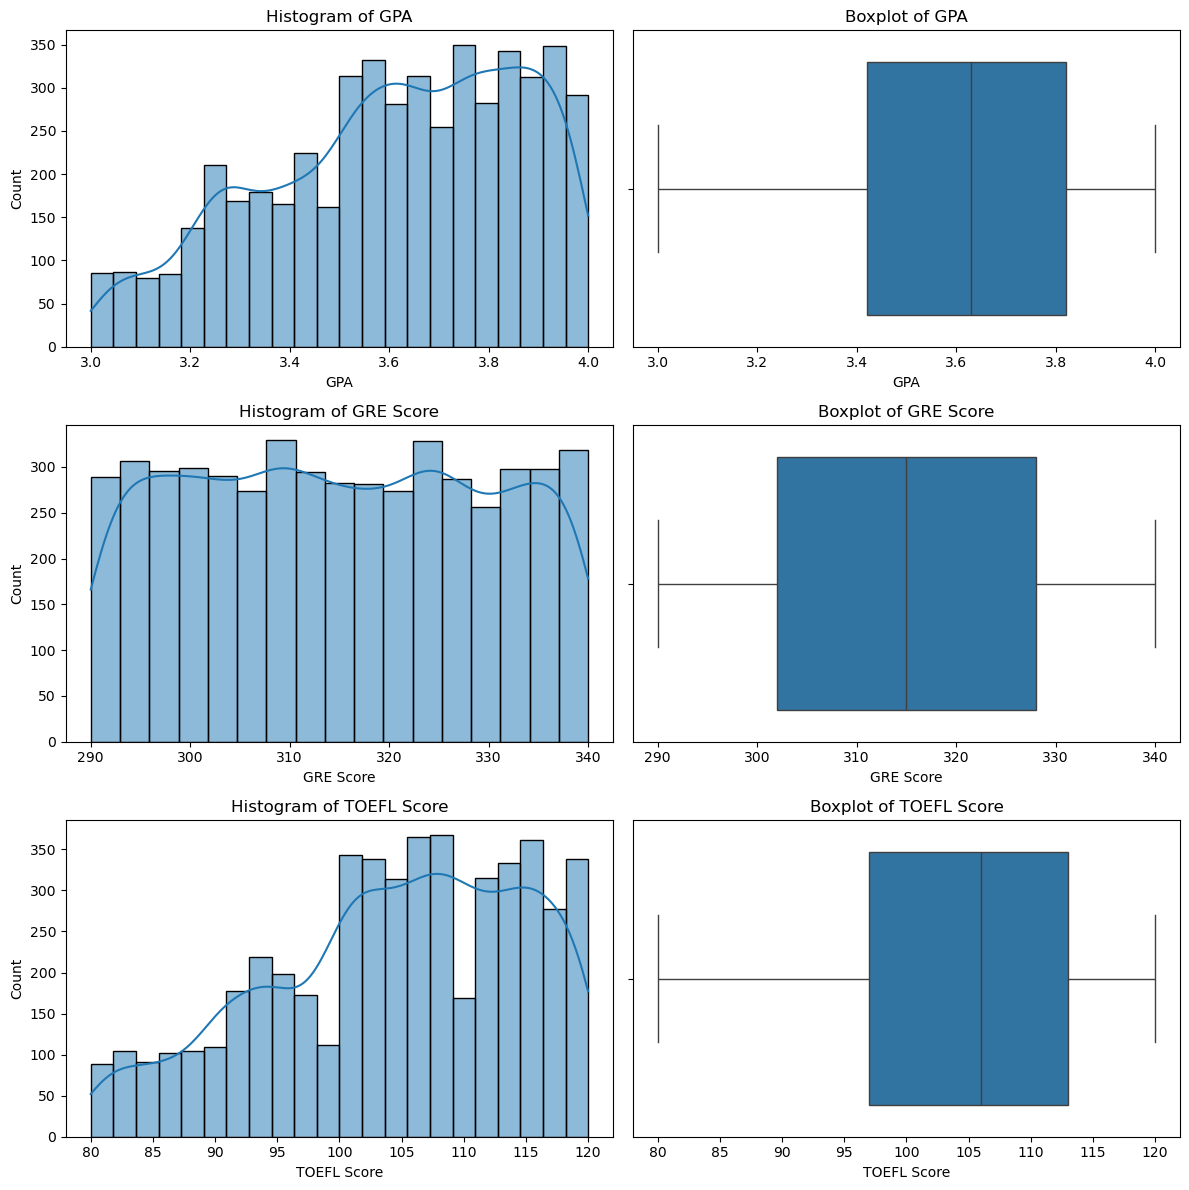

In [4]:
# Select numerical columns
numerical_cols = grades_dataset.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms and boxplots
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, len(numerical_cols) * 4))
for i, col in enumerate(numerical_cols):
    sns.histplot(grades_dataset[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=grades_dataset[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


### Identify skewness and outliers

In [5]:
# Calculate skewness of each numerical feature
skewness = grades_dataset[numerical_cols].apply(lambda x: skew(x))
print("Skewness of numerical features:")
print(skewness)


Skewness of numerical features:
GPA           -0.422375
GRE Score      0.016025
TOEFL Score   -0.446979
dtype: float64


In [6]:
# Function to find outliers using IQR
def find_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Apply to each feature and print outliers
for col in numerical_cols:
    outliers = find_outliers(grades_dataset, col)
    print(f"Outliers in {col}:", outliers.index.tolist())


Outliers in GPA: []
Outliers in GRE Score: []
Outliers in TOEFL Score: []


In [7]:
# Correcting skewness example using log transformation (where suitable)

for col in numerical_cols:
    if skew(grades_dataset[col]) > 0 or skew(grades_dataset[col]) < 0:
        grades_dataset[col] = np.log1p(grades_dataset[col])


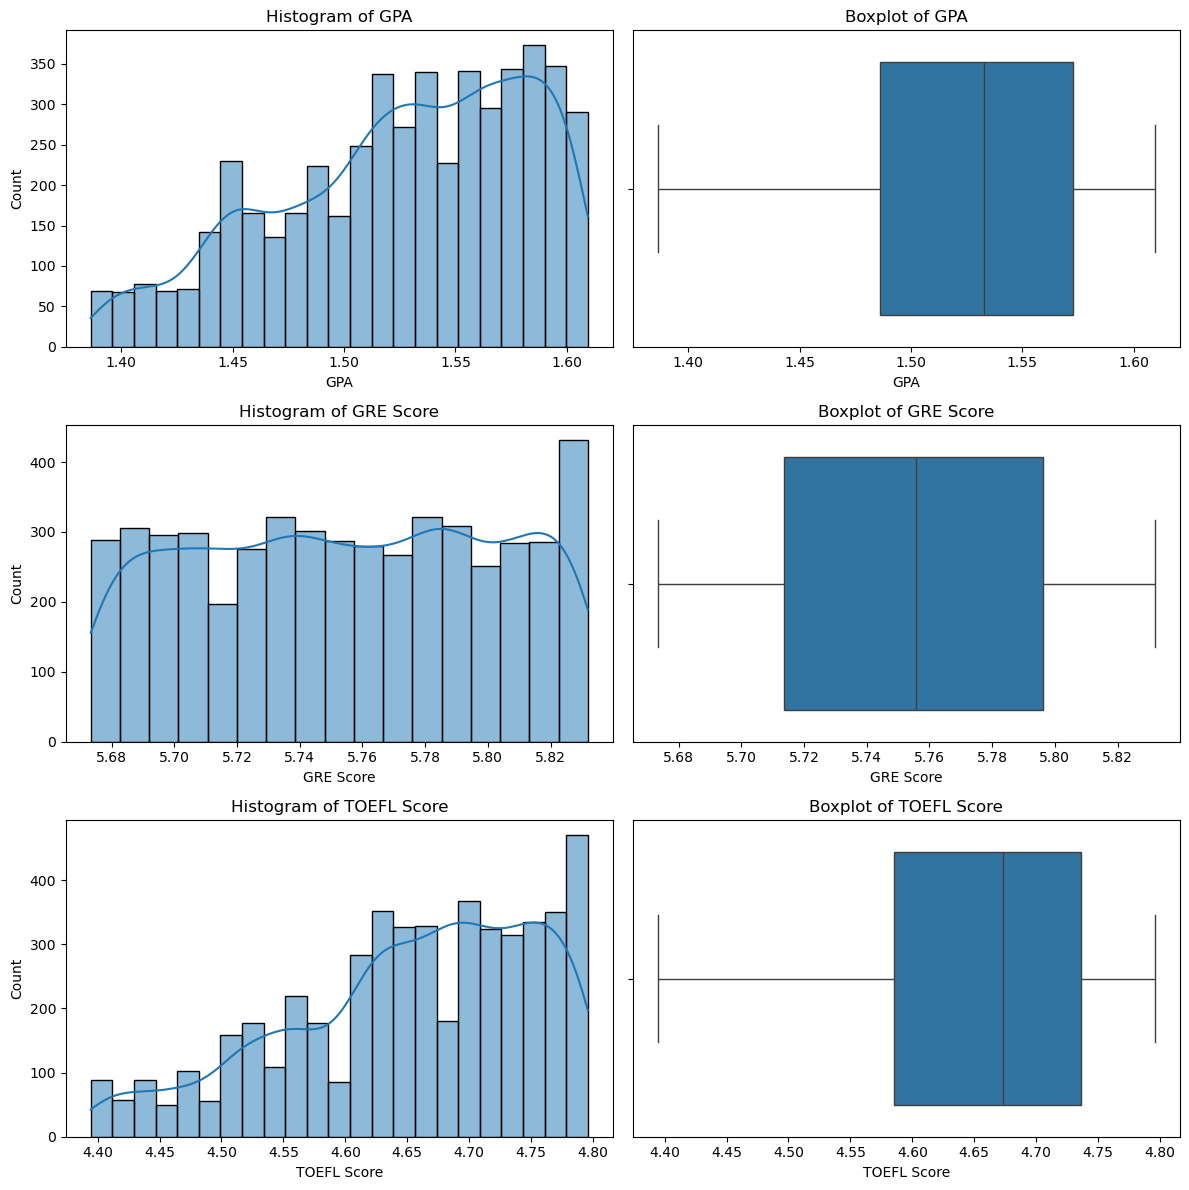

In [8]:
# Plot histograms and boxplots
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, len(numerical_cols) * 4))
for i, col in enumerate(numerical_cols):
    sns.histplot(grades_dataset[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=grades_dataset[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


### Dataset Pre-processing

In [9]:
grades_dataset_encoded = pd.get_dummies(grades_dataset, columns=['Program Name', 'Department'])

grades_dataset_encoded['Admission Accepted'] = grades_dataset['Admission Accepted'].apply(lambda x: 1 if x == 'Yes' else 0)

# Display the first few rows to confirm changes
grades_dataset_encoded.head()

,GPA,GRE Score,TOEFL Score,Admission Accepted,Program Name_Chemical & Biochemical Engineering,Program Name_Computer Engineering,Program Name_Computer Science,Program Name_Cybersecurity,Program Name_Data Science,Program Name_Electrical Engineering,...,Program Name_Environmental Engineering,Program Name_Health Information Technology,Program Name_Human-Centered Computing,Department_Chemical & Biochemical Engineering,Department_Civil & Environmental Engineering,Department_Computer Science,Department_Computer Science & Electrical Engineering,Department_Electrical Engineering,Department_Engineering Management,Department_Information Systems
0,1.523880,5.783825,4.644391,1,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
1,1.599388,5.777652,4.663439,0,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.425515,5.726848,4.653960,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1.530395,5.831882,4.553877,0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1.562346,5.823046,4.521789,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [10]:
# Define the features and the target
X = grades_dataset_encoded.drop('Admission Accepted', axis=1)
y = grades_dataset_encoded['Admission Accepted']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the model to disk
model_filename = r"C:\Users\sudhe\Projects\project_for_moeny\models\scaler.joblib"
dump(scaler, model_filename)

print(f"Model saved to {model_filename}")

Model saved to C:\Users\sudhe\Projects\project_for_moeny\models\scaler.joblib


In [17]:
X_test.columns

Index(['GPA', 'GRE Score', 'TOEFL Score',
       'Program Name_Chemical & Biochemical Engineering',
       'Program Name_Computer Engineering', 'Program Name_Computer Science',
       'Program Name_Cybersecurity', 'Program Name_Data Science',
       'Program Name_Electrical Engineering',
       'Program Name_Engineering Management',
       'Program Name_Environmental Engineering',
       'Program Name_Health Information Technology',
       'Program Name_Human-Centered Computing',
       'Department_Chemical & Biochemical Engineering',
       'Department_Civil & Environmental Engineering',
       'Department_Computer Science',
       'Department_Computer Science & Electrical Engineering',
       'Department_Electrical Engineering',
       'Department_Engineering Management', 'Department_Information Systems'],
      dtype='object')

### Re-sampling to tackle class imbalance

In [12]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### Training

Random Forest Classifier

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Accuracy on test set:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy on test set: 0.568
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.29      0.27      0.28       308
           1       0.68      0.70      0.69       692

    accuracy                           0.57      1000
   macro avg       0.48      0.49      0.48      1000
weighted avg       0.56      0.57      0.56      1000



In [14]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Accuracy on test set:", accuracy_score(y_test, y_pred_lr))
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy on test set: 0.466
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.30      0.55      0.39       308
           1       0.68      0.43      0.53       692

    accuracy                           0.47      1000
   macro avg       0.49      0.49      0.46      1000
weighted avg       0.56      0.47      0.48      1000



In [15]:
# Calculate the scale_pos_weight
# This is the ratio of number of negative class to the positive class
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize and train the XGBoost model with scale_pos_weight
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb.fit(X_train_smote, y_train_smote)  # Using SMOTE balanced data
y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost Accuracy on test set:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy on test set: 0.524
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.34      0.59      0.43       308
           1       0.73      0.49      0.59       692

    accuracy                           0.52      1000
   macro avg       0.54      0.54      0.51      1000
weighted avg       0.61      0.52      0.54      1000



### Parameter tuning - Gridsearch

In [40]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 6],
    'subsample': [0.8, 0.9, 1.0]
}


In [41]:
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', verbose=1)
grid_rf.fit(X_train_scaled, y_train)
print("Best parameters for RandomForest:", grid_rf.best_params_)
print("Best score for RandomForest:", grid_rf.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\ProgramData\anaconda3\envs\explore\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\explore\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\envs\explore\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\ProgramData\anaconda3\envs\explore\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constrai

Best parameters for RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score for RandomForest: 0.6849999999999999


In [42]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', verbose=1)
grid_lr.fit(X_train_smote, y_train_smote)
print("Best parameters for Logistic Regression:", grid_lr.best_params_)
print("Best score for Logistic Regression:", grid_lr.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\ProgramData\anaconda3\envs\explore\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\envs\explore\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.5145332342498554


In [43]:
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='accuracy', verbose=1)
grid_xgb.fit(X_train_smote, y_train_smote)
print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best score for XGBoost:", grid_xgb.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.9}
Best score for XGBoost: 0.6880614317562547


### Ensemble classification

In [46]:
# Assuming grid_lr, grid_rf, grid_xgb are the GridSearchCV objects for LogisticRegression, RandomForest, and XGBoost respectively
best_params_lr = grid_lr.best_params_
best_params_rf = grid_rf.best_params_
best_params_xgb = grid_xgb.best_params_

# Initialize the models with the best parameters
lr_best = LogisticRegression(**best_params_lr)
rf_best = RandomForestClassifier(**best_params_rf)
xgb_best = XGBClassifier(**best_params_xgb)


In [47]:
# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_best), ('rf', rf_best), ('xgb', xgb_best)],
    voting='soft'
)

In [71]:
# Train the ensemble model
voting_clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = voting_clf.predict(X_test_scaled)

# Evaluate the ensemble model
print("Accuracy of Ensemble Model:", accuracy_score(y_test, y_pred))
print("Classification Report for Ensemble Model:\n", classification_report(y_test, y_pred))

Accuracy of Ensemble Model: 0.595
Classification Report for Ensemble Model:
               precision    recall  f1-score   support

           0       0.32      0.29      0.31       308
           1       0.70      0.73      0.71       692

    accuracy                           0.59      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.58      0.59      0.59      1000



### Save the model

In [68]:
from joblib import dump

# Save the model to disk
model_filename = r"C:\Users\sudhe\Projects\project_for_moeny\models\admission_ensemble.joblib"
dump(voting_clf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to C:\Users\sudhe\Projects\project_for_moeny\models\admission_ensemble.joblib
